# Optical cavity alignment
A notebook for...
* Plotting transverse modes satisfying the paraxial wave equation
* Calculating overlap of input Gaussian beam with higher-order modes for misaligned cavity
* Plotting higher order mode spectrum

In [13]:
## general imports
import numpy as np
from numpy import *
fact = np.math.factorial

import scipy as sp
from scipy.integrate import quad, dblquad
from scipy.special import eval_hermite as Hermite
from scipy.special import eval_genlaguerre as Laguerre

from matplotlib import colors
import matplotlib.pyplot as plt
from time import time
from random import random as rand

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions
from physconsts import *

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
imagedir = os.path.join('.','images')
print("images saved in", imagedir)

C:\Users\prest\AppData\Local\Temp\ipykernel_11788\76292183.py:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display, Image


images saved in .\images


## Spatially multi-mode fields

In [2]:
def hermite_gaussian(m,n,w0):
    """
    return a function Amn(x,y) for the amplitude of the 
    (m,n)th Hermite-Gaussian beam, taking args x,y and 
    assuming the beam is in focus (z=0) with waist w0.
    """
    
    
    
    return lambda x,y: sqrt(2/(pi*2**(m+n)*fact(m)*fact(n)))*(
                        Hermite(n,sqrt(2)*x/w0)*Hermite(m,sqrt(2)*y/w0)
                        )*exp(-(x**2+y**2)/w0**2)/w0

def LG(p,l,w0):
    """
    return a function Apl(rho,phi) for the amplitude of the 
    (p,l)th Laguerre-Gaussian beam, taking args rho,phi and 
    assuming the beam is in focus (z=0) with waist w0.
    """
    eta2pl = 0 #(2*p+abs(l)+1)*eta(z) # guoy phase. not relevant for my purposes 
    def lg_pl(x,y): 
        rho = sqrt(x**2 + y**2)
        phi = arctan2(y,x)
        field = (sqrt(2*fact(p)/(pi*fact(p+abs(l))))*(sqrt(2)*rho/w0)**abs(l)
                 *Laguerre(p,abs(l),2*(rho/w0)**2)*exp(-1j*eta2pl)
                 *exp(-(rho/w0)**2)*exp(-1j*l*phi)/w0)
        return field
    return lg_pl

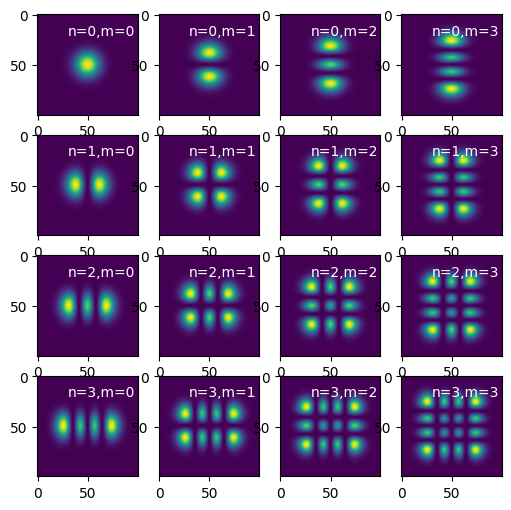

In [3]:
w0 = 1
hw = 3*w0
pts = 100
xarr, midpt, xx, yy = get_meshgrid(hw,pts)

nrange = 4
fig,axes = plt.subplots(nrange,nrange,figsize=(6,6))
for n in range(nrange):
    for m in range(nrange):
        mode = hermite_gaussian(m,n,w0)
        axes[n][m].imshow(mode(xx,yy)**2)
        axes[n][m].text(30,20,f'n={n},m={m}',color='white')

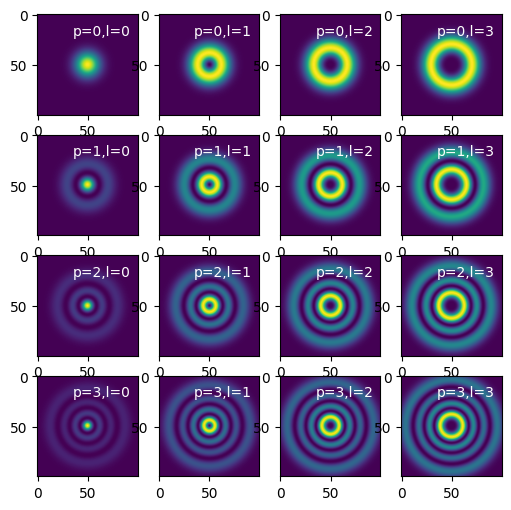

In [4]:
## sample of LG beams
w0 = 1
hw = 3*w0
pts = 100
xarr, midpt, xx, yy = get_meshgrid(hw,pts)

nrange = 4
fig,axes = plt.subplots(nrange,nrange,figsize=(6,6))
for l in range(nrange):
    for p in range(nrange):
        mode = LG(p,l,w0)
        axes[p][l].imshow(abs(mode(xx,yy))**2)
        axes[p][l].text(35,20,f'p={p},l={l}',color='white')

## Misaligned optical cavities
For a linear optical cavity made of two spherical mirrors, the cavity mode axis is the line which goes through the center of curvature of each mirror. A perturbation, i.e. a translation or tilt, of one of the mirrors will lead to a tilt in the mode axis. A fundamental Gaussian input beam aligned wrt to the unperturbed cavity mode axis and with the waist size and location matched to that of the unperturbed cavity, will then couple to higher-order modes.

In [99]:
def HGmn(w0,lmbda,m,n):
    """
    return a lambda function Amn(x,y,z) for the amplitude of the 
    (m,n)th Hermite-Gaussian beam with fundamental waist w0
    at location z.
    """
    
    k = 2*pi/lmbda # wavenumber
    zR = pi*w0**2/lmbda # Rayleigh range
    w = lambda z: w0*sqrt(1+(z/zR)**2) # width
    R = lambda z: z*(1+(zR/z)**2) # radius of curvature
    eta = lambda z: arctan(z/zR) # Guoy phase
    
    Amn = lambda x,y,z: (w0*sqrt(2/(pi*2**(m+n)*fact(m)*fact(n)))
                        *(Hermite(n,sqrt(2)*x/w(z))*Hermite(m,sqrt(2)*y/w(z)))
                        *exp(-(x**2+y**2)/w(z)**2)
                        *exp(1j*k*(x**2+y**2)/(2*R(z)))
                        *exp(-1j*(1+m+n)*eta(z))/w(z))
    return Amn


def dblquad_complex(func, ax, bx, ay, by, **kwargs):
    """
    Compute a double integral of a complex function.
    Adapted from https://devpress.csdn.net/python/6304554b7e6682346619a05b.html
    
    returns a 3-tuple (result, real error, imaginary part error)
    """
    def real_func(x,y):
        return real(func(x,y))
    def imag_func(x,y):
        return imag(func(x,y))
    real_integral = dblquad(real_func, ax, bx, hfun=ay, gfun=by, **kwargs)
    imag_integral = dblquad(imag_func, ax, bx, hfun=ay, gfun=by, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])

In [102]:
## verify that the HG beams are orthonormal

mm = 10**-3
w0 = 0.1*mm
lmbda = 7.8*10**-4*mm
z = 10**-6*mm

# overlap of any mode with itself should be 1
A00 = HGmn(w0,lmbda,0,0)
integrand = lambda x,y: conjugate(A00(x,y,z))*A00(x,y,z)

overlap = dblquad_complex(integrand, ax=-inf, bx=inf, ay=-inf, by=inf)
print(overlap)
# assert overlap[0] == 1, print(overlap)

A11 = HGmn(w0,lmbda,1,1)
integrand = lambda x,y: conjugate(A11(x,y,z))*A11(x,y,z)

overlap = dblquad_complex(integrand, ax=-inf, bx=inf, ay=-inf, by=inf)
print(overlap)
# assert overlap[0] == 1, print(overlap)

# overlap of any mode with any different mode should be 0
A01 = HGmn(w0,lmbda,0,1)
integrand = lambda x,y: conjugate(A00(x,y,z))*A01(x,y,z)

overlap = dblquad_complex(integrand, ax=-inf, bx=inf, ay=-inf, by=inf)
assert overlap[0] == 0, print(overlap)

A22 = HGmn(w0,lmbda,2,2)
integrand = lambda x,y: conjugate(A11(x,y,z))*A22(x,y,z)

overlap = dblquad_complex(integrand, ax=-inf, bx=inf, ay=-inf, by=inf)
assert overlap[0] == 0, print(overlap)

((-0+0j), (0,), (0,))
((-0+0j), (0,), (0,))


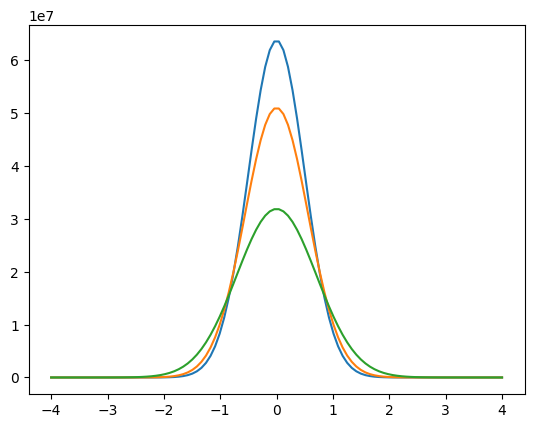

In [93]:
zR = pi*w0**2/lmbda
zpts = [10**-8, 0.5*zR, zR]
I00 = lambda x,y,z: conjugate(A00(x,y,z))*A00(x,y,z)
for z in zpts:
    xpts = linspace(-4*w0,4*w0,100)
    plt.plot(xpts/w0,real(I00(xpts,0,z)))
#     plt.plot(xpts/w0,imag(I00(xpts,0,z)))

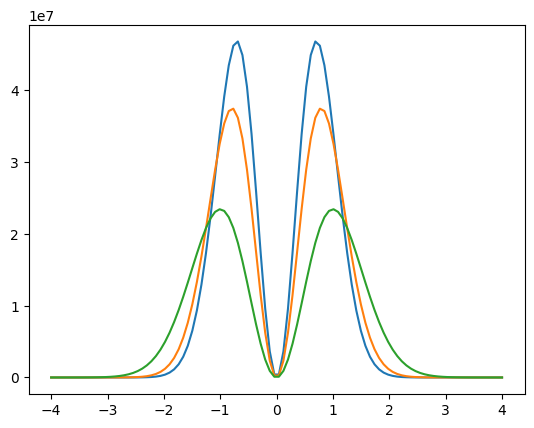

In [94]:
zR = pi*w0**2/lmbda
zpts = [10**-8, 0.5*zR, zR]
I01 = lambda x,y,z: conjugate(A01(x,y,z))*A01(x,y,z)
for z in zpts:
    xpts = linspace(-4*w0,4*w0,100)
    plt.plot(xpts/w0,real(I01(xpts,0,z)))
#     plt.plot(xpts/w0,imag(I01(xpts,0,z)))

## Integration tests

In [ ]:
def quad_complex(func, a, b, **kwargs):
    """
    Compute a single integral of a complex function.
    Adapted from https://devpress.csdn.net/python/6304554b7e6682346619a05b.html
    """
    def real_func(x):
        return real(func(x))
    def imag_func(x):
        return imag(func(x))
    real_integral = quad(real_func, a, b, **kwargs)
    imag_integral = quad(imag_func, a, b, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])

def dblquad_complex(func, ax, bx, ay, by, **kwargs):
    """
    Compute a double integral of a complex function.
    Adapted from https://devpress.csdn.net/python/6304554b7e6682346619a05b.html
    
    returns a 3-tuple (result, real error, imaginary part error)
    """
    def real_func(x,y):
        return real(func(x,y))
    def imag_func(x,y):
        return imag(func(x,y))
    real_integral = dblquad(real_func, ax, bx, hfun=ay, gfun=by, **kwargs)
    imag_integral = dblquad(imag_func, ax, bx, hfun=ay, gfun=by, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])

In [43]:
quad_complex(lambda x: (exp(1j*x)), a=0, b=pi/2)

((0.9999999999999999+0.9999999999999999j),
 (1.1102230246251564e-14,),
 (1.1102230246251564e-14,))

In [44]:
dblquad_complex(lambda x,y: (exp(1j*sqrt(x**2+y**2))), ax=-10, bx=10, ay=-10, by=10)

((38.44378720197425+3.8434453352689872j),
 (8.617970226332261e-11,),
 (5.481955719108238e-08,))

## Speckle fields

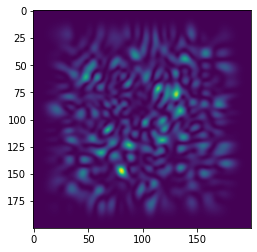

In [12]:
# Make a spatially multi-mode laser field

w0 = 10 # units mm
hw = 5*w0
pts = 200
xarr, midpt, xx, yy = get_meshgrid(hw,pts)

nrange = 20

def multimode_field(nrange,w0,gridhw,pts):
    """
    Returns a Hermite Gaussian multimode field 
    
    Args:
        nrange: maximum mode number. modes will go up H.G.(nrange, nrange)
        w0: Gaussian waist w0
        gridhw: the realspace halfwidth of the output grid
        pts: the number of pixels in 1D; full output will be pts x pts
    Return:
        field: the complex field of dimensions of the meshgrid coordinates
    """
    field = zeros((pts,pts), complex)
    _,_,xx,yy = get_meshgrid(gridhw,pts)
    
    for n in range(nrange):
        for m in range(nrange):
            field += hermite_gaussian(m,n,w0)(xx,yy)*exp(-1j*2*pi*rand())
    return field

field = multimode_field(nrange,w0,hw,pts)
I2xy = real(field*conjugate(field))
I2xy /= amax(I2xy)
fig,ax = plt.subplots()
ax.imshow(I2xy)

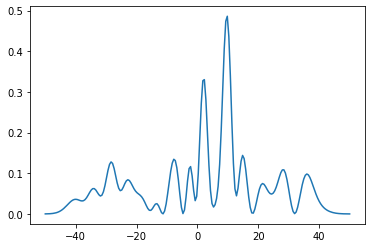

In [13]:
plt.plot(xarr, I2xy[100,])
# plt.ylim(0,0.025)

In [ ]:
## does the speckle diffract out?

In [28]:
lmbda = 0.0008 # mm
k = 2*pi/lmbda
_,_,rr,phi = get_meshgrid(hw,pts,polar=True)
padding = pts
field1 = field

z = 10
calculated field2 in 0.02536773681640625 s
z = 100
calculated field2 in 0.020860671997070312 s
z = 1000
calculated field2 in 0.031501054763793945 s


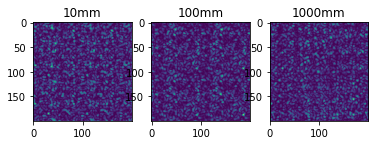

In [29]:
zsteps = [10,100,1000]
fig,axes = plt.subplots(nrows=1,ncols=len(zsteps))
for z,ax in zip(zsteps,axes):
    field2,x2pts = propagate(z, field1, k, xarr, rr, padding, padval=0, logging=True)
    I2xy = real(field2*conjugate(field2))
    I2xy /= amax(I2xy)
    ax.imshow(I2xy)
    ax.set_title(f"{z}mm")

In [23]:
field1.shape

(200, 200)

In [24]:
field2.shape

(200, 200)

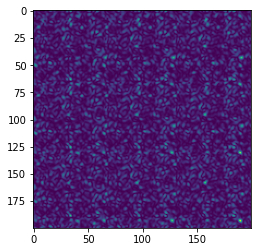

In [25]:
I2xy = real(field2*conjugate(field2))
I2xy /= amax(I2xy)
fig,ax = plt.subplots()
ax.imshow(I2xy)

In [21]:
propagate?